Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
using CmdStan, StanMCMCChain
gr(size=(500,500));

┌ Info: Precompiling StatisticalRethinking [2d09df54-9d0f-5258-8220-54c2a3d4fbee]
└ @ Base loading.jl:1186
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for ForwardDiff [f6369f11-7733-5829-9624-2563aa707210]
│   exception = Required dependency CommonSubexpressions [bbf7d656-a473-5ed7-a52c-81e309532950] failed to load from a cache file.
└ @ Base loading.jl:969
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Optim [429524aa-4258-5aef-a3af-852621145aeb]
│   exception = Required dependency ForwardDiff [f6369f11-7733-5829-9624-2563aa707210] failed to load from a cache file.
└ @ Base loading.jl:969
┌ Warning: Replacing module `ForwardDiff`
└ @ Base loading.jl:878
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for KernelDensity [5ab0869b-81aa-558d-bb23-cbf5423bbe9b]
│   exception = Required dependency ForwardDiff [f6369f11-7733-5829-9624-2563aa707210] failed to load from a cac

loaded


┌ Warning: The call to compilecache failed to create a usable precompiled cache file for StatisticalRethinking [2d09df54-9d0f-5258-8220-54c2a3d4fbee]
│   exception = ErrorException("Required dependency KernelDensity [5ab0869b-81aa-558d-bb23-cbf5423bbe9b] failed to load from a cache file.")
└ @ Base loading.jl:969
┌ Info: Precompiling StatPlots [60ddc479-9b66-56df-82fc-76a74619b69c]
└ @ Base loading.jl:1186
┌ Warning: Package Turing does not have CmdStan in its dependencies:
│ - If you have Turing checked out for development and have
│   added CmdStan as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Turing
│ Loading CmdStan into Turing from project dependency, future warnings for Turing are suppressed.
└ @ nothing nothing:840


CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "chapters", "04")
cd(ProjDir)

### snippet 4.48

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


Center weight and store as weight_c

In [5]:
mean_weight = mean(df2[:weight])
df2 = hcat(df2, df2[:weight] .- mean_weight)
rename!(df2, :x1 => :weight_c); # Rename our col :x1 => :weight_c

Define the Stan language model

In [6]:
weightsmodel = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] height; // Predictor
 vector[N] weight; // Outcome
}

parameters {
 real alpha; // Intercept
 real beta; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
 height ~ normal(alpha + weight * beta , sigma);
}

generated quantities {
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [ ]:
stanmodel = Stanmodel(name="weights", monitors = ["alpha", "beta", "sigma"],model=weightsmodel,
  output_format=:mcmcchain);

Input data for cmdstan

In [7]:
heightsdata = [
  Dict("N" => length(df2[:height]), "height" => df2[:height], "weight" => df2[:weight_c])
];

=====> /Users/rob/.julia/dev/StatisticalRethinking/chapters/04



Sample using cmdstan

In [8]:
rc, chn, cnames = stan(stanmodel, heightsdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME)
# ### Snippet 4.47
# Show first 5 individual draws of correlated parameter values in chain 1
chn.value[1:5,:,1]


make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

Calling /Users/rob/Projects/StanSupport/cmdstan/bin/stansummary to infer across chains.

Inference for Stan model: weights_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.25, 0.21, 0.22, 0.20) seconds, 0.88 seconds total
Sampling took (0.21, 0.18, 0.18, 0.32) seconds, 0.90 seconds total

                Mean     MCSE  StdDev    5%   50%   95%    N_Eff  N_Eff/s    R_hat
lp__            -747  2.6e-02     1.2  -750  -747  -746  2.1e+03  2.4e+03  1.0e+00
accept_stat__   0.92  1.3e-03   0.090  0.74  0.96   1.0  4.8e+03  5.3e+03  1.0e+00
stepsize__      0.75  2.7e-02   0.038  0.71  0.75  0.81  2.0e+00  2.2e+00  2.9e+13
treedepth__      2.5  1.4e-02    0.83   1.0   2.0   4.0  3.4e+03  3.8e+03  1.0e+00
n_leapfrog__     7.5  1.1e+00 

5×3 Array{Union{Missing, Float64},2}:
 154.484  0.899809  5.30817
 154.764  0.909978  4.89338
 154.557  0.921197  5.0204 
 154.562  0.858195  5.17784
 154.262  0.870407  5.12158

### Snippets 4.48 & 4.49

Plot estimates using the N = [10, 50, 150, 352] observations

In [9]:
p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
nvals = [10, 50, 150, 352]

4-element Array{Int64,1}:
  10
  50
 150
 352

Create plots

In [10]:
for i in 1:length(nvals)
  N = nvals[i]
  heightsdataN = [
    Dict("N" => N, "height" => df2[1:N, :height], "weight" => df2[1:N, :weight_c])
  ]
  rc, chnN, cnames = stan(stanmodel, heightsdataN, ProjDir, diagnostics=false,
    summary=false, CmdStanDir=CMDSTAN_HOME)

  rws, vars, chns = size(chnN[:, 1, :])
  xi = -15.0:0.1:15.0
  alpha_vals = convert(Vector{Float64}, reshape(chnN.value[:, 1, :], (rws*chns)))
  beta_vals = convert(Vector{Float64}, reshape(chnN.value[:, 2, :], (rws*chns)))

  p[i] = scatter(df2[1:N, :weight_c], df2[1:N, :height], leg=false, xlab="weight_c")
  for j in 1:N
    yi = alpha_vals[j] .+ beta_vals[j]*xi
    plot!(p[i], xi, yi, title="N = $N")
  end
end
plot(p..., layout=(2, 2))


make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.


### Snippet 4.50

Get dimensions of chains

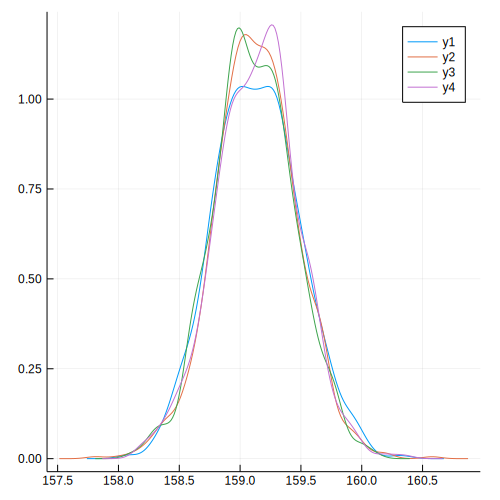

In [11]:
rws, vars, chns = size(chn[:, 1, :])
mu_at_50 = link(50:10:50, chn, [1, 2], mean_weight);
density(mu_at_50)

### Snippet 4.54

Show posterior density for 6 mu_bar values

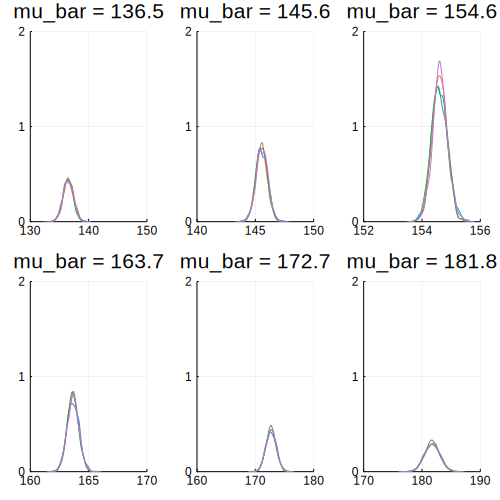

In [12]:
mu = link(25:10:75, chn, [1, 2], mean_weight);

q = Vector{Plots.Plot{Plots.GRBackend}}(undef, size(mu, 1))
for i in 1:size(mu, 1)
  q[i] = density(mu[i], ylim=(0.0, 1.5),
    leg=false, title="mu_bar = $(round(mean(mu[i]), digits=1))")
end

plot(q..., layout=(2, 3), ticks=(3))

End of `clip_48_51s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*